# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
'''
Warnings are issued to alert the user of certain conditions which aren't exactly exceptions.
Typically warning appears if some deprecated usage of certain programming element like
 keyword/function/class etc. is found.
 '''
import warnings, gc
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [2]:
#!pip install skforecast

# Scikit-Learn (Sklearn)
Scikit-learn (Sklearn) is the most useful and robust library for machine learning in Python. It provides a selection of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction via a consistence interface in Python. This library, which is largely written in Python, is built upon NumPy, SciPy and Matplotlib.

In [3]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.impute import *

# Skforecast
 Skforecast is a Python library that eases using scikit-learn regressors as single and multi-step forecasters. It also works with any regressor compatible with the scikit-learn API (pipelines, CatBoost, LightGBM, XGBoost, Ranger...).\
 The fields of statistics and machine learning have developed many excellent regression algorithms that can be useful for forecasting, but applying them effectively to time series analysis can still be a challenge. To address this issue, the skforecast library provides a comprehensive set of tools for training, validation and prediction in a variety of scenarios commonly encountered when working with time series.

In [4]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Load the Dataset

In [5]:
data = pd.read_csv('/content/Tesla_split_adjusted.csv')
data.head()

,date,open,high,low,close,volume,raw_close,change_percent,avg_vol_20d
0,2010-06-29,1.26666,1.66666,1.16934,1.59266,281749173,23.8899,NaN,NaN
1,2010-06-30,1.71934,2.02794,1.55334,1.58866,257915884,23.8299,-0.25,NaN
2,2010-07-01,1.66666,1.72800,1.35134,1.46400,123447940,21.9600,-7.85,NaN
3,2010-07-02,1.53334,1.54000,1.24734,1.28000,77127102,19.2000,-12.57,NaN
4,2010-07-06,1.33334,1.33334,1.05534,1.07400,103189435,16.1100,-16.09,NaN


In [6]:
# Assuming you already have a DataFrame 'df' with a column named 'date'
# Convert the 'date' column to datetime objects

data['date'] = pd.to_datetime(data['date'])

In [7]:
df=data[data['date'] <= '2019-12-31']
df.tail()

,date,open,high,low,close,volume,raw_close,change_percent,avg_vol_20d
2389,2019-12-24,27.89066,28.36466,27.51250,28.35000,120820795,425.2500,1.44,1.348438e+08
2390,2019-12-26,28.52734,28.89866,28.42334,28.72934,159724343,430.9401,1.34,1.368628e+08
2391,2019-12-27,29.00000,29.02066,28.40734,28.69200,149352398,430.3800,-0.13,1.401579e+08
2392,2019-12-30,28.58600,28.60000,27.28392,27.64666,189019042,414.6999,-3.64,1.477596e+08
2393,2019-12-31,27.00000,28.08600,26.80534,27.88866,154386893,418.3299,0.88,1.509175e+08


In [8]:
#formating the float
'''
Python Lambda Functions are anonymous function means that the function is without a name.
As we already know that the def keyword is used to define a normal function in Python.
Similarly, the lambda keyword is used to define an anonymous function in Python.
'''
float_cols = df.select_dtypes(np.float64).columns
for c in float_cols:
    df[c] = df[c].apply(lambda x: np.round(x,3))

In [9]:
# data sampling
#sampling the data for last n years

n = 2
end_year = df['date'].dt.year.max()
start_year = end_year - n

df = df.loc[(df['date'].dt.year >= start_year)
                     & (df['date'].dt.year <= end_year)]

In [10]:
# set index
df.set_index('date', inplace=True)

In [11]:
# filtering columns

wanted = ['open', 'high', 'low' , 'close']
df = df[wanted]

In [12]:
# set frequency
'''Pandas fills the gaps that may exist in the time series
   with the value of NULL. Here the frequency is set to business days'''

df = df.asfreq('B',method='ffill')
df.head()

,open,high,low,close
date,,,,
2017-01-03,14.324,14.689,14.064,14.466
2017-01-04,14.317,15.200,14.287,15.133
2017-01-05,15.095,15.165,14.797,15.117
2017-01-06,15.129,15.354,15.030,15.267
2017-01-09,15.265,15.461,15.200,15.419


# Train-test data splitting  
Train test splittechnique is used to estimate the performance of machine learning algorithms which are used to make predictions on data not used to train the model.

In [13]:
# train & test data split

size = 200  # last n days
data_train = df[:-size]
data_test  = df[-size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
print()

Train dates : 2017-01-03 00:00:00 --- 2019-03-26 00:00:00  (n=581)
Test dates  : 2019-03-27 00:00:00 --- 2019-12-31 00:00:00  (n=200)



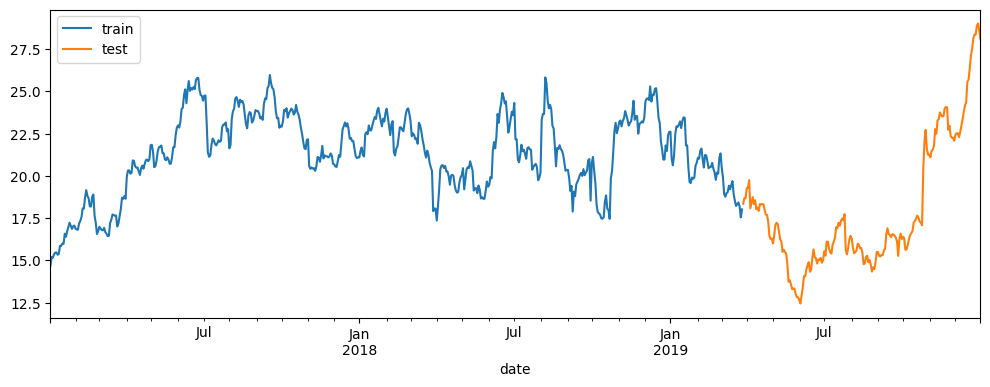

In [14]:
# plot the training & validation data

col = 'high'
fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
ax.legend();

# Recursive Autoregressive Forecasting

---
**ForecasterAutoreg**\
With this class, a model is created and trained from "RandomForestRegressor" with a time window of n lags. This means that the model uses the previous n days as predictors

In [15]:
# Create and train forecasterAutoreg

n_days = 120
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(criterion = 'absolute_error',
                random_state= np.random.randint(100)),
                lags      = n_days)

forecaster.fit(y=data_train[col])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(criterion='absolute_error', random_state=71) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-03 00:00:00'), Timestamp('2019-03-26 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'boots

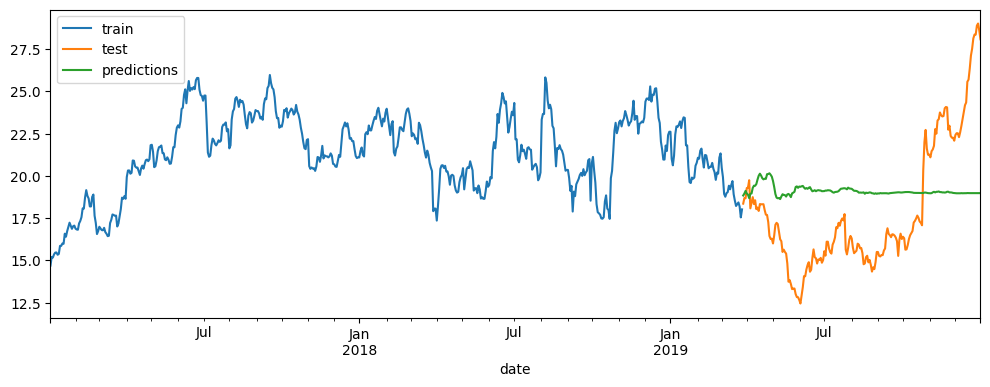

In [16]:
# future prediction
# once trained, the model predicts n days in future

n_future_days = 200
preds = forecaster.predict(steps=n_future_days)

# plot the predicted data

fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
preds.plot(ax=ax, label='predictions')
ax.legend();

In [17]:
# Test error

'''The error that the model makes in its predictions is quantified.
    The metric used is the mean absolute error (mae)'''

error = mean_absolute_error(
                y_true = data_test[col],
                y_pred = preds
            )

print(f"Mean Absolute Error: {'{:.3f}'.format(error)}")

Mean Absolute Error: 3.576


# Hyperparameter Tuning
Skforecast library provides the grid_search_forecaster function. It compares the results obtained with multiple combinations of hyperparameters and lags, and identify the best one

In [18]:
# hyperparameter grid search

forecaster_tune = ForecasterAutoreg(
                regressor = RandomForestRegressor(criterion = 'absolute_error', random_state= np.random.randint(100)),
                lags      = n_days # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [150, 180, 200]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster_tune,
                        y                  = data_train[col],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                         steps              = n_future_days,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
               )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 1.5769501374570

# Final Model

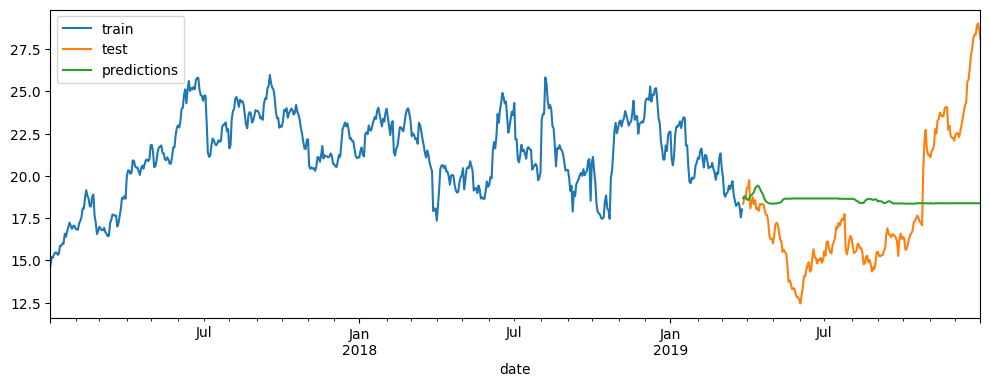

In [19]:
# create regressor and train the forecaster with the best hyperparameters

regressor_tune = RandomForestRegressor(max_depth=3, n_estimators=100, criterion = 'absolute_error',
                                       random_state= np.random.randint(100))
forecaster_opt = ForecasterAutoreg(
                regressor = regressor_tune,
                lags      = 200)

forecaster_opt.fit(y=data_train[col])


# predictions with new & optimized forecaster

preds_opt = forecaster_opt.predict(steps=n_future_days)

# plot the new predicted data

fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
preds_opt.plot(ax=ax, label='predictions')
ax.legend();